# 1-D Interpolation

In [ ]:
import numpy as np
import scipy.interpolate as scintp
import scipy.optimize as scopt
import matplotlib.pyplot as plt

In [ ]:
def Psat(T):
    A, B, C = 5.08354, 1663.125, -45.622
    log10P = A - B/(T+C)
    return 10**log10P

In [ ]:
Pvap = 2
Tsat = scopt.newton(lambda T:Psat(T)-Pvap, 373)
Tsat-273.16

120.2134941928282

In [ ]:
listT = np.linspace(273, 473, 1000)
listP = Psat(listT)
Tsat = scintp.UnivariateSpline(listP, listT, k=3)

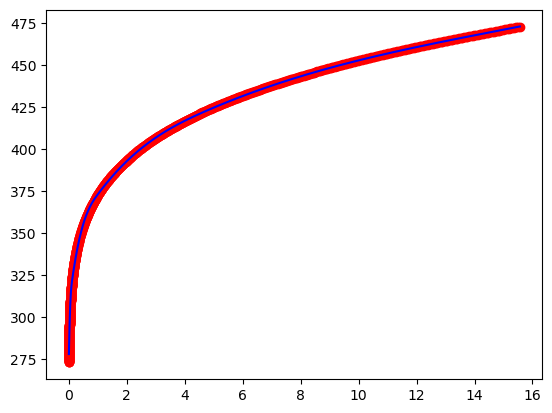

In [ ]:
plt.plot(listP, listT, 'ro')
plt.plot(listP, Tsat(listP),'b')

# Multi-variate interpolation
This is useful when a mathematical model either cannot be fitted to the data or if the model is too onerous to code.  Univariate splines etc cannot be readily generalized to multivariate interpolation.  This is where machine learning comes in.

First import the data.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel("HNO3-H2O-MgNO3-VLE.xlsx", sheet_name='Consolidated',
                  skiprows=1)
df

,T,MgL,NitricL,NitricV,Source
0,127.0,0.3347,0.2893,0.729,THOMPSON
1,133.5,0.4883,0.1265,0.672,THOMPSON
2,140.5,0.5509,0.0592,0.578,THOMPSON
3,146.5,0.6390,0.0309,0.498,THOMPSON
4,151.5,0.6069,0.0315,0.414,THOMPSON
...,...,...,...,...,...
115,137.0,0.6375,0.1001,0.952,GINNOW_CLARK
116,148.0,0.6560,0.0525,0.775,GINNOW_CLARK
117,143.0,0.6215,0.0715,0.827,GINNOW_CLARK
118,150.0,0.6450,0.0300,0.672,GINNOW_CLARK


In [ ]:
df.describe()

,T,MgL,NitricL,NitricV
count,120.00000,120.000000,120.000000,120.000000
mean,132.48750,0.443411,0.154678,0.547169
std,15.40122,0.186489,0.158559,0.299386
min,103.20000,0.077000,0.000300,0.007000
25%,120.77500,0.299500,0.043125,0.304600
50%,130.35000,0.469150,0.092000,0.565000
75%,142.62500,0.602325,0.220500,0.816000
max,175.00000,0.707000,0.754000,1.017000


Here the input variables are MgL and NitricL i.e. the composition of the liquid phase.  The outputs are T and NitricV (since the pressure is constant at 1 atm).  Let's begin with estimating T (which is called the bubble point temperature) as a function of the liquid composition.

In [ ]:
X = df[['MgL','NitricL']].copy()
y = df['T'].copy()

In [ ]:
import sklearn
import sklearn.model_selection

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
X, y, test_size = 0.2, random_state = 42
)

# Linear Regression
We will first try a simple linear regression.  It is probably not going to work - but we can try.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()
model = model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

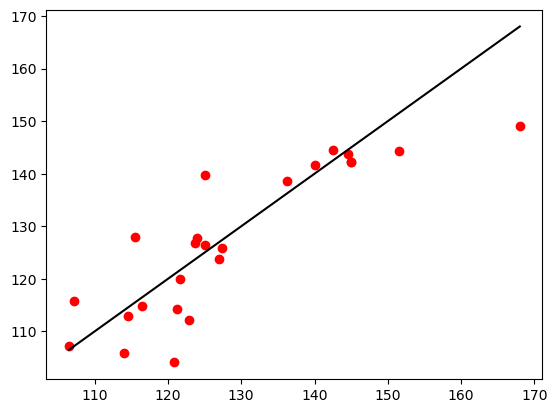

In [ ]:
plt.plot(y_test, y_pred, 'ro')
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k')

In [ ]:
def get_r2(ypred, yexpt):
    ymean = np.mean(yexpt)
    SSE = np.sum((ypred-yexpt)**2)
    SSM = np.sum((ypred-ymean)**2)
    r2 = 1 - SSE/SSM
    return r2

In [ ]:
get_r2(y_pred, y_test)

0.6914306954563881

This is actually better than expected, but still not good enough to design e.g. a distillation column.  We need something in the range of r2=0.9.

One thing we can try is cross multiples of the independent variables i.e. if a and b are the independent variables, we can generate additional variables of the form $a^2$, $ab$, $b^2$, $a^3$, $a^2b$,$ab^2$, $b^3$ etc.  Lets do that.

In [ ]:
X['M2'] = X['MgL']**2
X['N2'] = X['NitricL']**2
X['MN'] = X['MgL']*X['NitricL']

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
X, y, test_size = 0.2, random_state = 42
)

In [ ]:
model = LinearRegression()
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

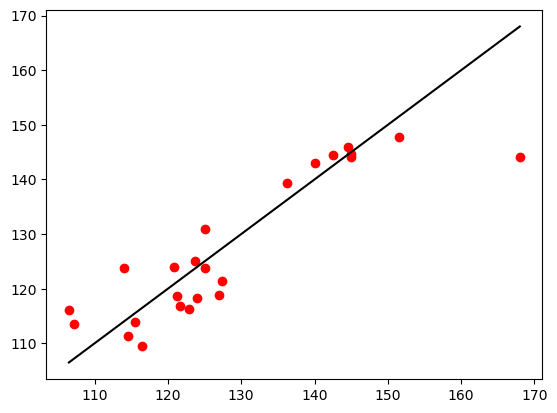

In [ ]:
plt.plot(y_test, y_pred, 'ro')
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k')

In [ ]:
get_r2(y_pred, y_test)

0.7070039976311249

So that didn't help at all.

# Kernel Ridge Regression
So linear regression is out.  Let's try something called a kernel ridge regression.  The kernels are 'cosine', 'additive_chi2', 'linear', 'laplacian', 'chi2', 'rbf', 'precomputed', 'poly', 'polynomial', 'sigmoid'

In [ ]:
from sklearn.kernel_ridge import KernelRidge

In [ ]:
X = df[['MgL','NitricL']]
y = df['T']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
X, y, test_size = 0.2, random_state = 42
)

In [ ]:
model = KernelRidge(alpha=0.01, kernel='laplacian')
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

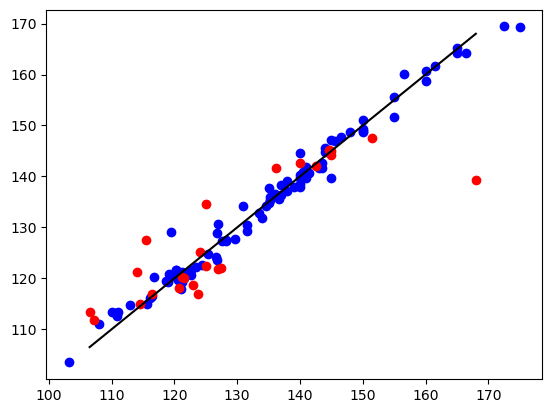

In [ ]:
plt.plot(y_train, y_pred_train, 'bo')
plt.plot(y_test, y_pred, 'ro')

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k')

In [ ]:
get_r2(y_pred, y_test)

0.5896087656677578

The Laplacian does a really good job of the interpolation.  But does it really?  So let's change the liquid composition smoothly and look at the effect on temperature.  We will keep weight fraction of water at 50% and smoothly change the weight fractions of MgL and NitricL as follows.

In [ ]:
ML = np.linspace(0.1, 0.4, 1000)
NL = 0.5 - ML
XL = pd.DataFrame({
    'MgL':ML,
    'NitricL':NL
})
Tpred = model.predict(XL)
plt.plot(ML, Tpred, 'r')

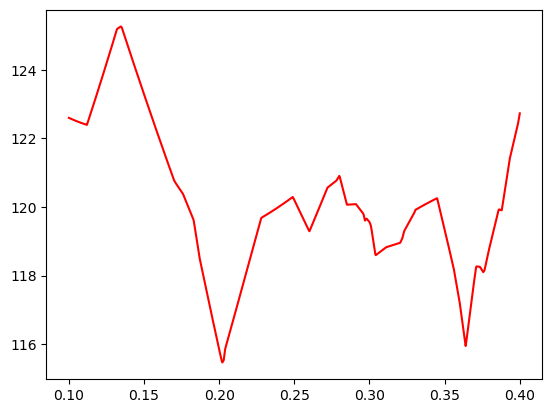

In [ ]:
plt.plot(ML, Tpred, 'r')

One would have expected the temperature to change smoothly as well.  But it doesn't.  It changes in a very jagged way - in a manner that is useless for applications in engineering design.

# Random Forest Regression

In [ ]:
X = df[['MgL','NitricL']]
y = df['T']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
X, y, test_size = 0.2, random_state = 42
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5)
rfr = rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

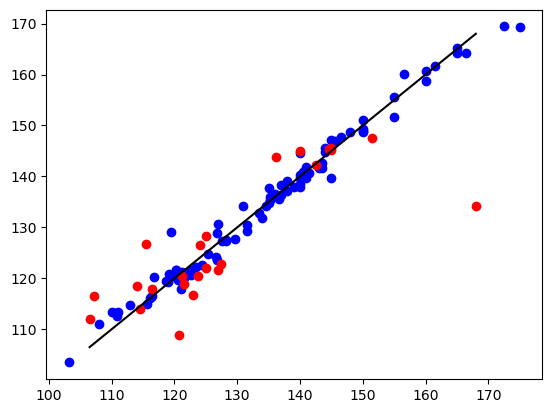

In [ ]:
plt.plot(y_train, y_pred_train, 'bo')
plt.plot(y_test, y_pred, 'ro')

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k')

In [ ]:
get_r2(y_pred, y_test)

0.5135860623218049

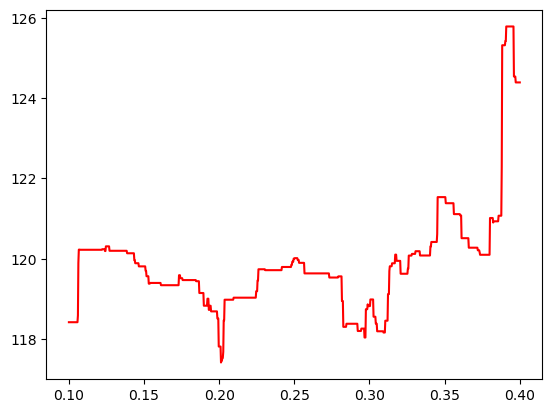

In [ ]:
ML = np.linspace(0.1, 0.4, 1000)
NL = 0.5 - ML
XL = pd.DataFrame({
    'MgL':ML,
    'NitricL':NL
})
Tpred = rfr.predict(XL)
plt.plot(ML, Tpred, 'r')

# Gaussian Process Regression
So random forest is better than Kernel Ridge regression because it at least get the trend in temperature right - increasing concentration of Mg(NO3)2 should increase temperature.  However, it does not give a smooth curve.  So lets try Gaussian Process Regression.

0.18648850358529911

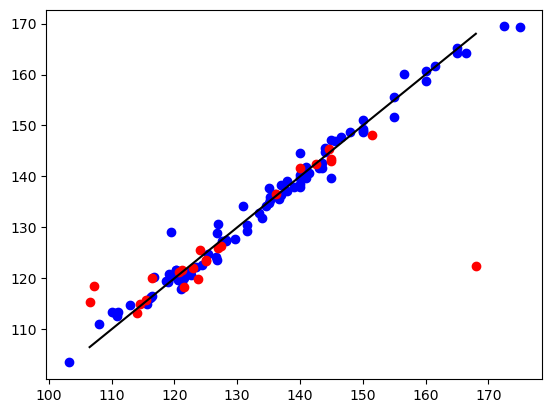

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()
gpr = gpr.fit(X_train, y_train)
y_pred = gpr.predict(X_test)

plt.plot(y_train, y_pred_train, 'bo')
plt.plot(y_test, y_pred, 'ro')

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k')

get_r2(y_pred, y_test)

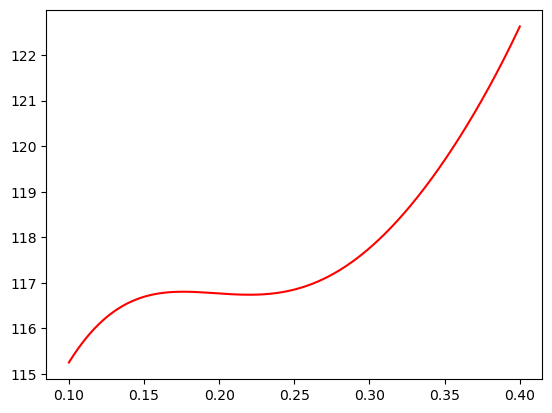

In [ ]:
ML = np.linspace(0.1, 0.4, 1000)
NL = 0.5 - ML
XL = pd.DataFrame({
    'MgL':ML,
    'NitricL':NL
})
Tpred = gpr.predict(XL)
plt.plot(ML, Tpred, 'r')

So in a Gaussian Process regressor, the fit is not super good, but the curve is very smooth - good for use in engineering calculations.

So if we promise never to exceed the bounds of the experiments, a Gaussian Process regressor can be a wonderful multivariate interpolant.

0.9442427885305289

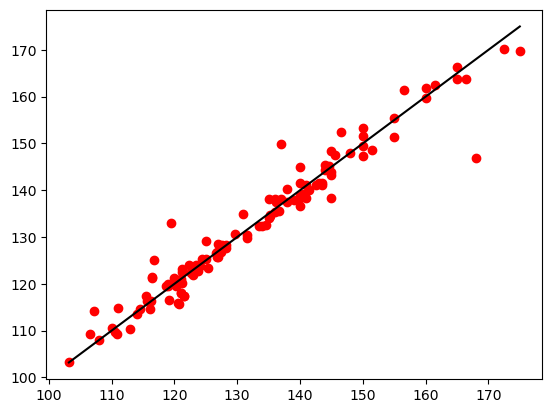

In [ ]:
gpr_full = GaussianProcessRegressor()
gpr_full = gpr_full.fit(X, y)
y_pred = gpr_full.predict(X)

plt.plot(y, y_pred, 'ro')

plt.plot([min(y),max(y)], [min(y),max(y)], 'k')

get_r2(y_pred, y)

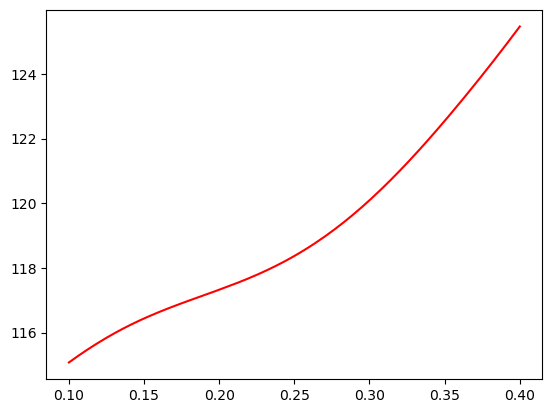

In [ ]:
ML = np.linspace(0.1, 0.4, 1000)
NL = 0.5 - ML
XL = pd.DataFrame({
    'MgL':ML,
    'NitricL':NL
})
Tpred = gpr_full.predict(XL)
plt.plot(ML, Tpred, 'r')

# Artificial Neural Network
There is a theorem called the 'Universal Approximation Theorem' that states that a neural network of 3 layers (input, 1 hidden, output) can approximate any scalar function.  Let's put this theorem to test with our data.

0.6914255185480409

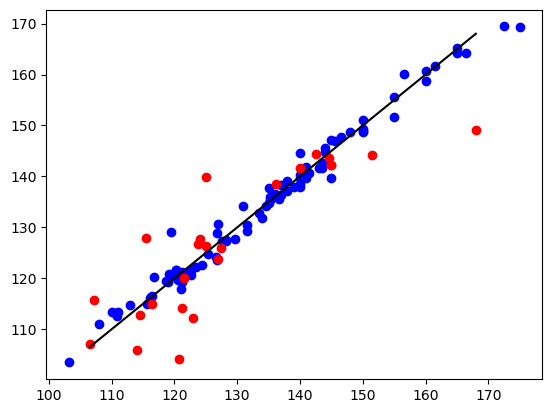

In [ ]:
from sklearn.neural_network import MLPRegressor

ann = MLPRegressor(hidden_layer_sizes=(10,), solver='lbfgs')
ann = ann.fit(X_train, y_train)
y_pred = ann.predict(X_test)

plt.plot(y_train, y_pred_train, 'bo')
plt.plot(y_test, y_pred, 'ro')

plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k')

get_r2(y_pred, y_test)

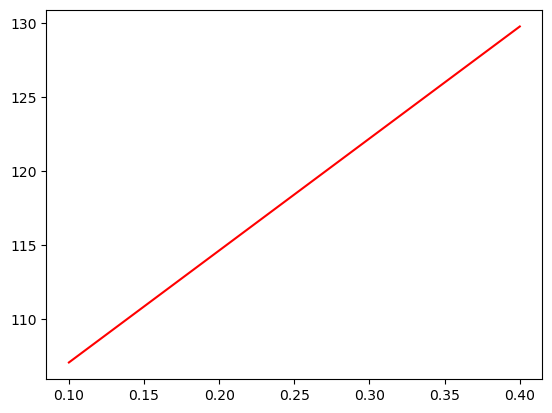

In [ ]:
ML = np.linspace(0.1, 0.4, 1000)
NL = 0.5 - ML
XL = pd.DataFrame({
    'MgL':ML,
    'NitricL':NL
})
Tpred = ann.predict(XL)
plt.plot(ML, Tpred, 'r')

Let's see how good it is as a pure interpolant.

0.8698213732868811

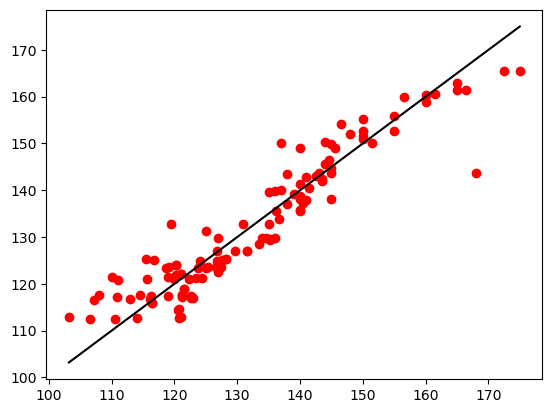

In [ ]:
ann_full = MLPRegressor(hidden_layer_sizes=(10,), solver='lbfgs',
                        activation = 'logistic')
ann_full = ann.fit(X, y)
y_pred = ann.predict(X)

plt.plot(y, y_pred, 'ro')

plt.plot([min(y),max(y)], [min(y),max(y)], 'k')

get_r2(y_pred, y)

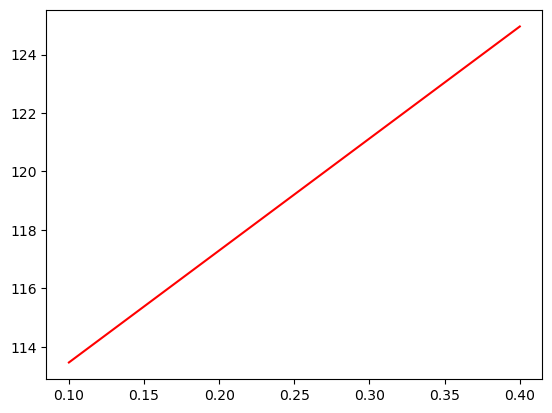

In [ ]:
ML = np.linspace(0.1, 0.4, 1000)
NL = 0.5 - ML
XL = pd.DataFrame({
    'MgL':ML,
    'NitricL':NL
})
Tpred = ann_full.predict(XL)
plt.plot(ML, Tpred, 'r')

So ANN is not as good an interpolant as the Gaussian Process even if you use 100 perceptrons in the hidden layer.  Actually, 10 perceptrons work better than 100.